In [1]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from amftrack.util.dbx import upload_folders, load_dbx, download, get_dropbox_folders
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
)
from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-03-21 12:44:16.425391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 12:44:16.834593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/home2/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/cv2/../../lib64:
2023-03-21 12:44:16.834629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29

In [2]:
plates = [
    "799_20211001",
    "803_20211012",
    "809_20211012",
    "907_20220321",
    "943_20220322",
    "403_20221005",
    "408_20221013",
    "88_20210915",
    "790_20210907",
    "69_20201119",
    "94_20201123",
    "59_20201126",
    "139_20201214",
    "40_20201214",
    "599_20201217",
]
# plates = [
#     "139_20201214",
#     # "40_20201214",
#     # "799_20211001",
    
# ]
directory_targ = directory_project
update_analysis_info(directory_targ)
analysis_info = get_analysis_info(directory_targ)
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(plates)]
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/3345 [00:00<?, ?it/s]

In [3]:
analysis_folders = analysis_info.loc[analysis_info["unique_id"].isin(["94_20201123"])]
analysis_folders

,folder_analysis,version,total_path,Plate,strain,medium,CrossDate,date,unique_id,datetime,...,path_time_hypha_info,path_time_plate_info,path_global_plate_info,date_run_analysis,PrincePos,root,split,Pbait,Temperature,Temp
36,Analysis_94_20201123_166_Version1,Version1,/scratch-shared/amftrack/stitch_temp2/20201123...,94,'A5','001P100N','20201123',"23.11.2020, 12:53:",94_20201123,2020-11-23 12:53:00,...,Analysis_94_20201123_166_Version1/time_hypha_info,Analysis_94_20201123_166_Version1/time_plate_i...,Analysis_94_20201123_166_Version1/global_plate...,"01.01.1970, 01:00:",39,'Carrot','Y',nan,nan,'25'


In [3]:
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.loc[folders["/Analysis/skeleton_realigned_compressed.mat"] == True]
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,Temp,unique_id,datetime
1389,/projects/0/einf914/data/20201217_0835_Plate09,139,9,'Carrot','A5','001P100N','Y','-',20201214,NaN,...,False,True,True,True,True,"17.12.2020, 08:35:",20201217_0835_Plate09,25,139_20201214,2020-12-17 08:35:00


In [8]:
folders

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,Temp,unique_id,datetime
1047,/projects/0/einf914/data/20201127_1409_Plate39,94,39,'Carrot','A5','001P100N','Y',NaN,'20201123',NaN,...,False,True,True,True,True,"27.11.2020, 14:09:",20201127_1409_Plate39,'25',94_20201123,2020-11-27 14:09:00
1345,/projects/0/einf914/data/20201127_1508_Plate39,94,39,'Carrot','A5','001P100N','Y',NaN,'20201123',NaN,...,False,True,True,True,True,"27.11.2020, 15:08:",20201127_1508_Plate39,'25',94_20201123,2020-11-27 15:08:00


In [37]:
from amftrack.pipeline.launching.run_super import run_parallel_post

time = "2:00:00"
list_f = [plot_betweenness_random]


list_args = [[]] * len(list_f)
overwrite = True
num_parallel = 6
run_parallel_post(
    "exp_plot_no_label.py",
    list_f,
    list_args,
    [directory_targ, overwrite],
    analysis_folders,
    num_parallel,
    time,
    "plot_bet",
    cpus=128,
    name_job='bet',
    node="fat",
    dependency=True
)

Submitted batch job 2411275


In [3]:
from amftrack.pipeline.launching.run_super import run_parallel, run_launcher
plates = [
    "799_20211001",
    "803_20211012",
    "809_20211012",
    "907_20220321",
    "943_20220322",
    "403_20221005",
    "408_20221013",
    "88_20210915",
    "790_20210907",
    "69_20201119",
    "94_20201123",
    "59_20201126",
    "139_20201214",
    "40_20201214",
    "599_20201217",
]
# plates = [
#     "139_20201214",
#     # "40_20201214",
#     # "799_20211001",
    
# ]
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
folders = folders.loc[folders["/Analysis/skeleton_realigned_compressed.mat"] == True]
num_parallel = 128
time = "12:00:00"
skip = False
resolution = 10
args = [directory_targ, skip, resolution]
run_parallel(
    "extract_betweeness.py",
    args,
    folders,
    num_parallel,
    time,
    "betweenness",
    cpus=128,
    node="fat",
    name_job='bet',
)

Submitted batch job 2410390
Submitted batch job 2410391
Submitted batch job 2410392
Submitted batch job 2410393
Submitted batch job 2410394
Submitted batch job 2410395
Submitted batch job 2410396


In [3]:
folders = all_folders.loc[all_folders["unique_id"]=='94_20201123']
folders = folders.sort_values(by="datetime")
folders = folders.iloc[70:72]

exp = Experiment(directory_targ)
exp.load(folders)
exp.dates.sort()
for t in range(len(folders)):
    exp.load_tile_information(t)

2020-11-27 14:09:00
2020-11-27 15:08:00


In [4]:
load_graphs(exp,directory_targ)
exp.save_location = ''

load_study_zone(exp)


In [5]:
t = len(folders)-1
exp.load_tile_information(t)
spore_datatable = make_spore_data(exp)
spore_datatable = spore_datatable.loc[spore_datatable['t']==t]

In [6]:
spore_datatable.to_csv('spore_94.csv')

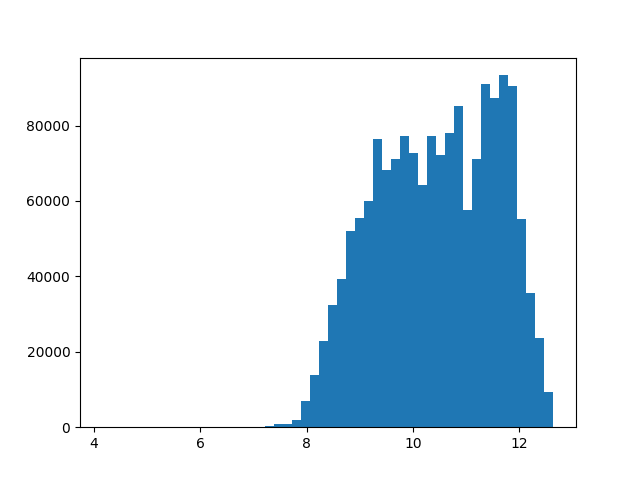

In [22]:
f = lambda edge : np.log(edge.width(t)*edge.length_um(t)*edge.end.degree(t)*edge.begin.degree(t))
edges = get_all_edges(exp, t)
values = [f(edge) for edge in edges]
weights = [edge.length_um(t) for edge in edges]

fig,ax = plt.subplots()
h = ax.hist(values,50,weights = weights)

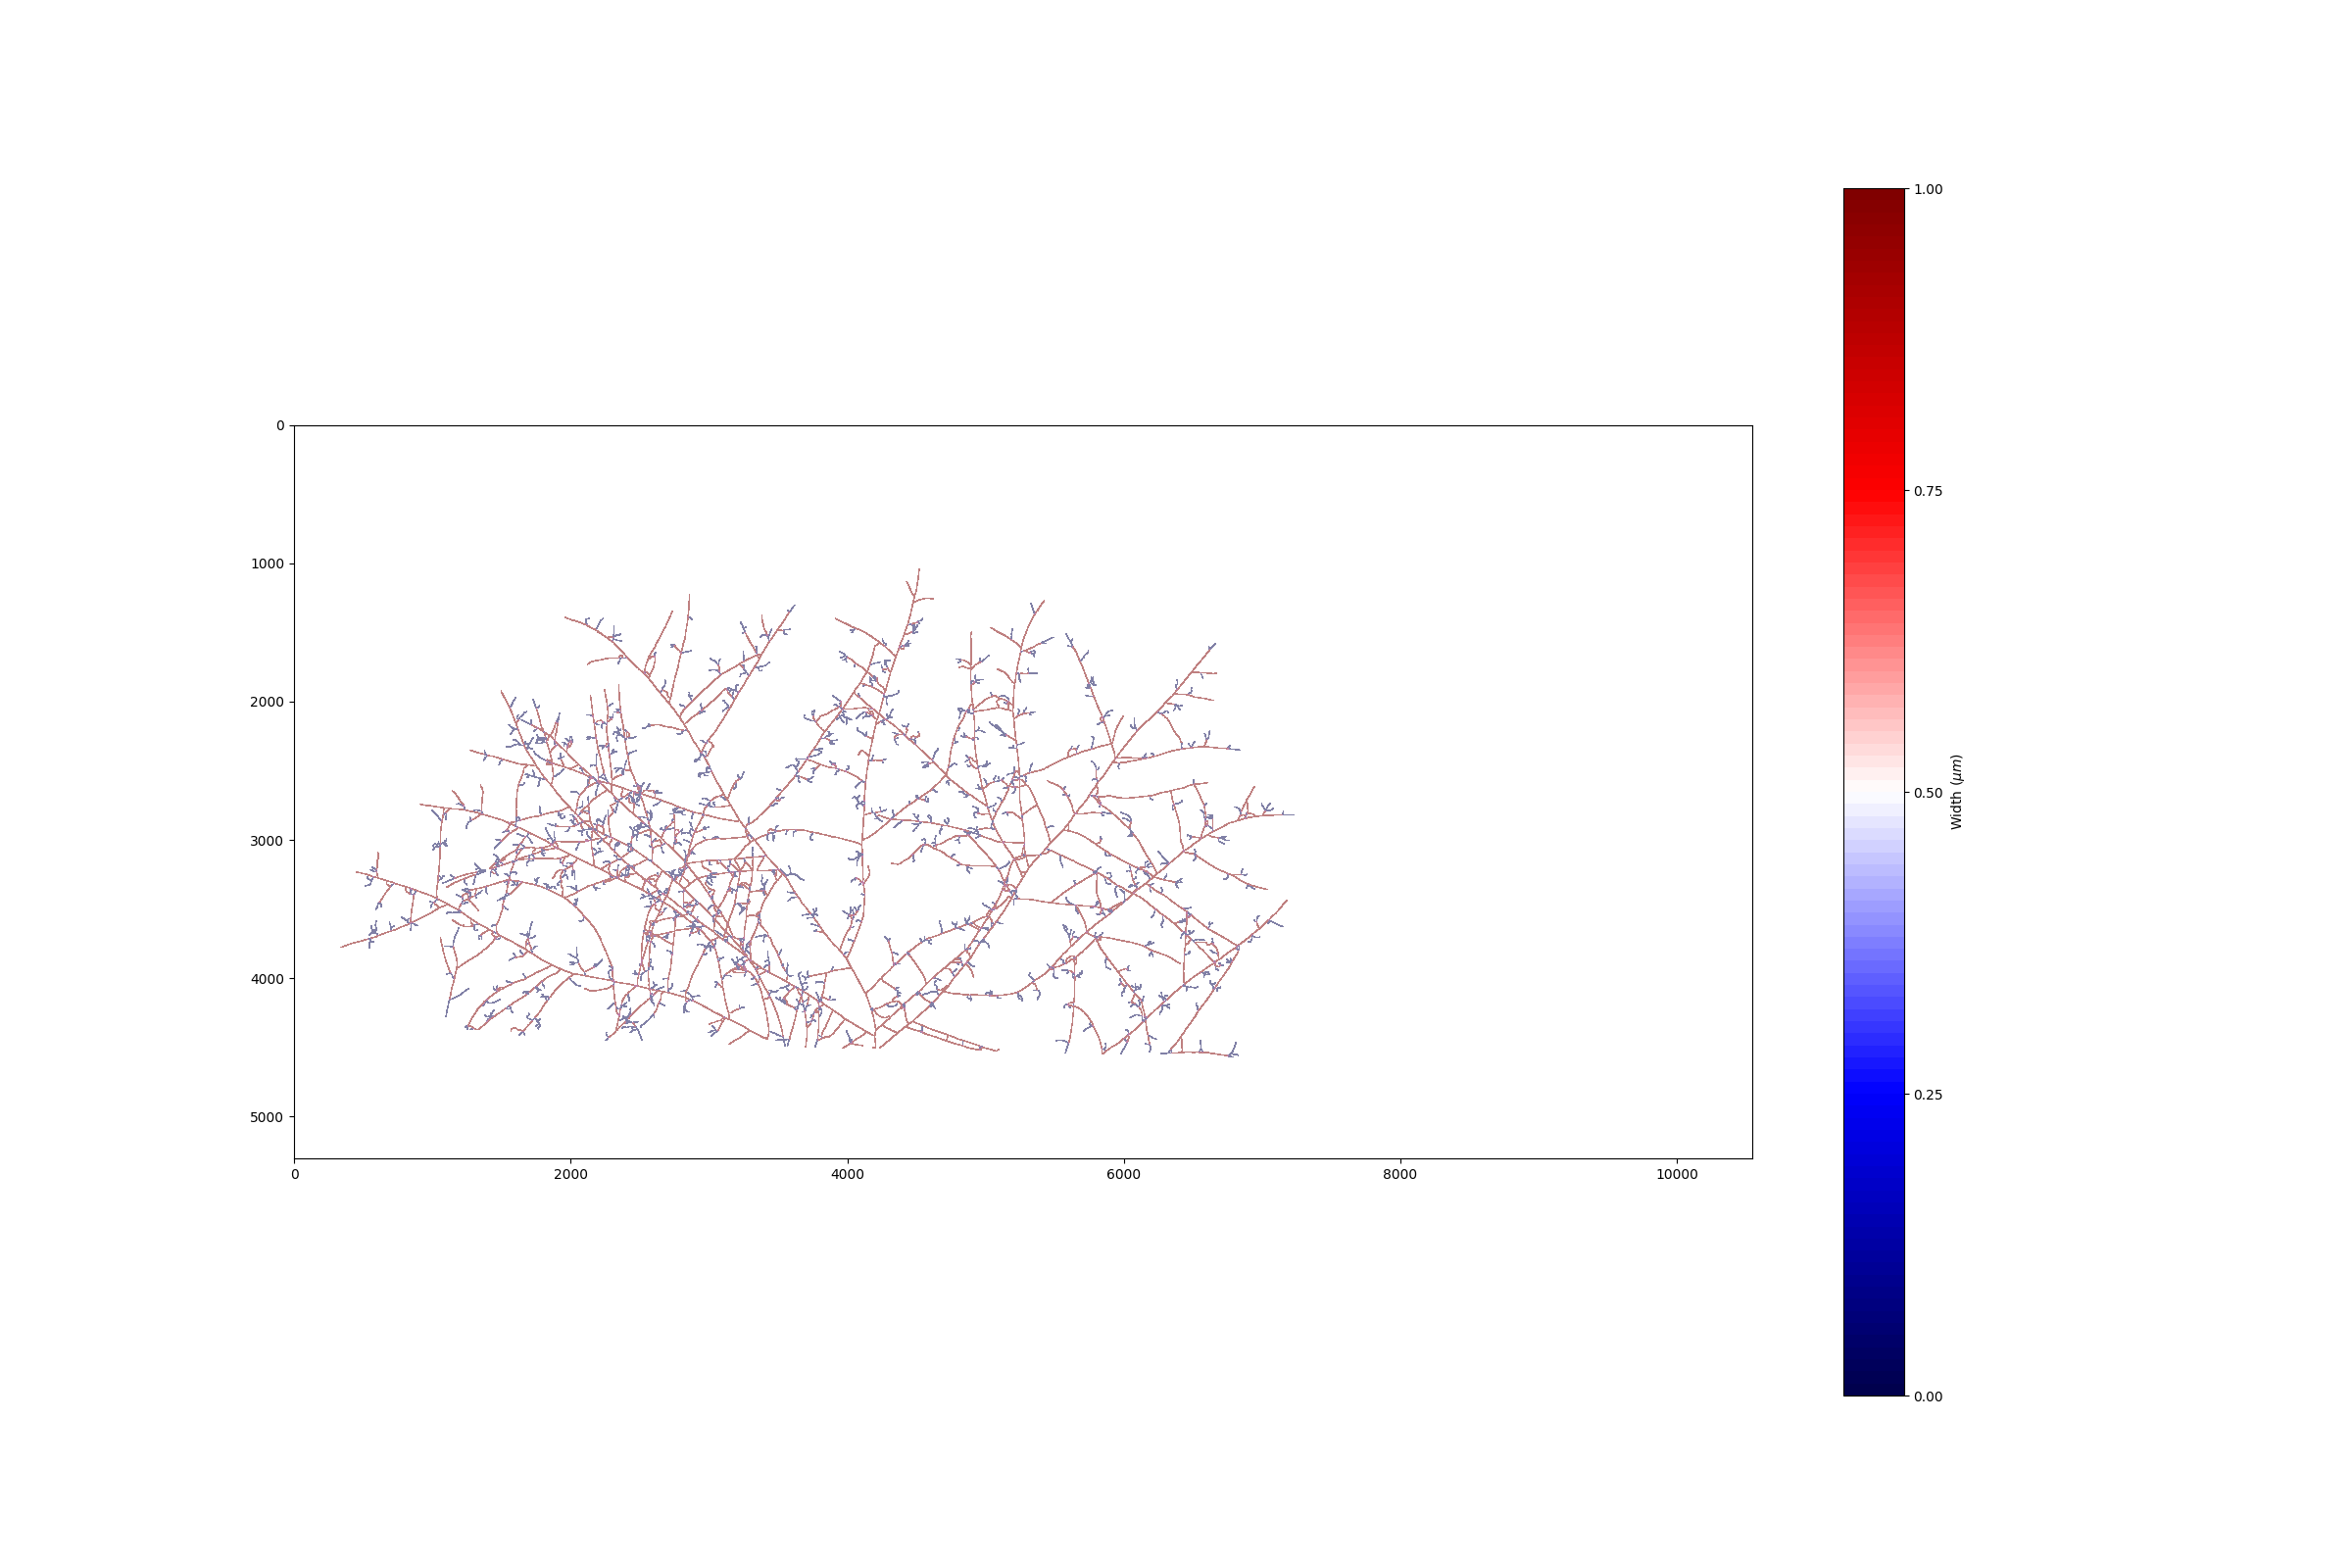

In [21]:
dpi=400

vmax = 1
vmin = 0
plot_edge_color_value(exp,t,lambda edge : f(edge)>10,cmap = cm.get_cmap("seismic", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10,figsize = (24,16))
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f'BAS.png'
save_path = os.path.join(path,file_name)
plt.savefig(save_path, dpi=dpi)

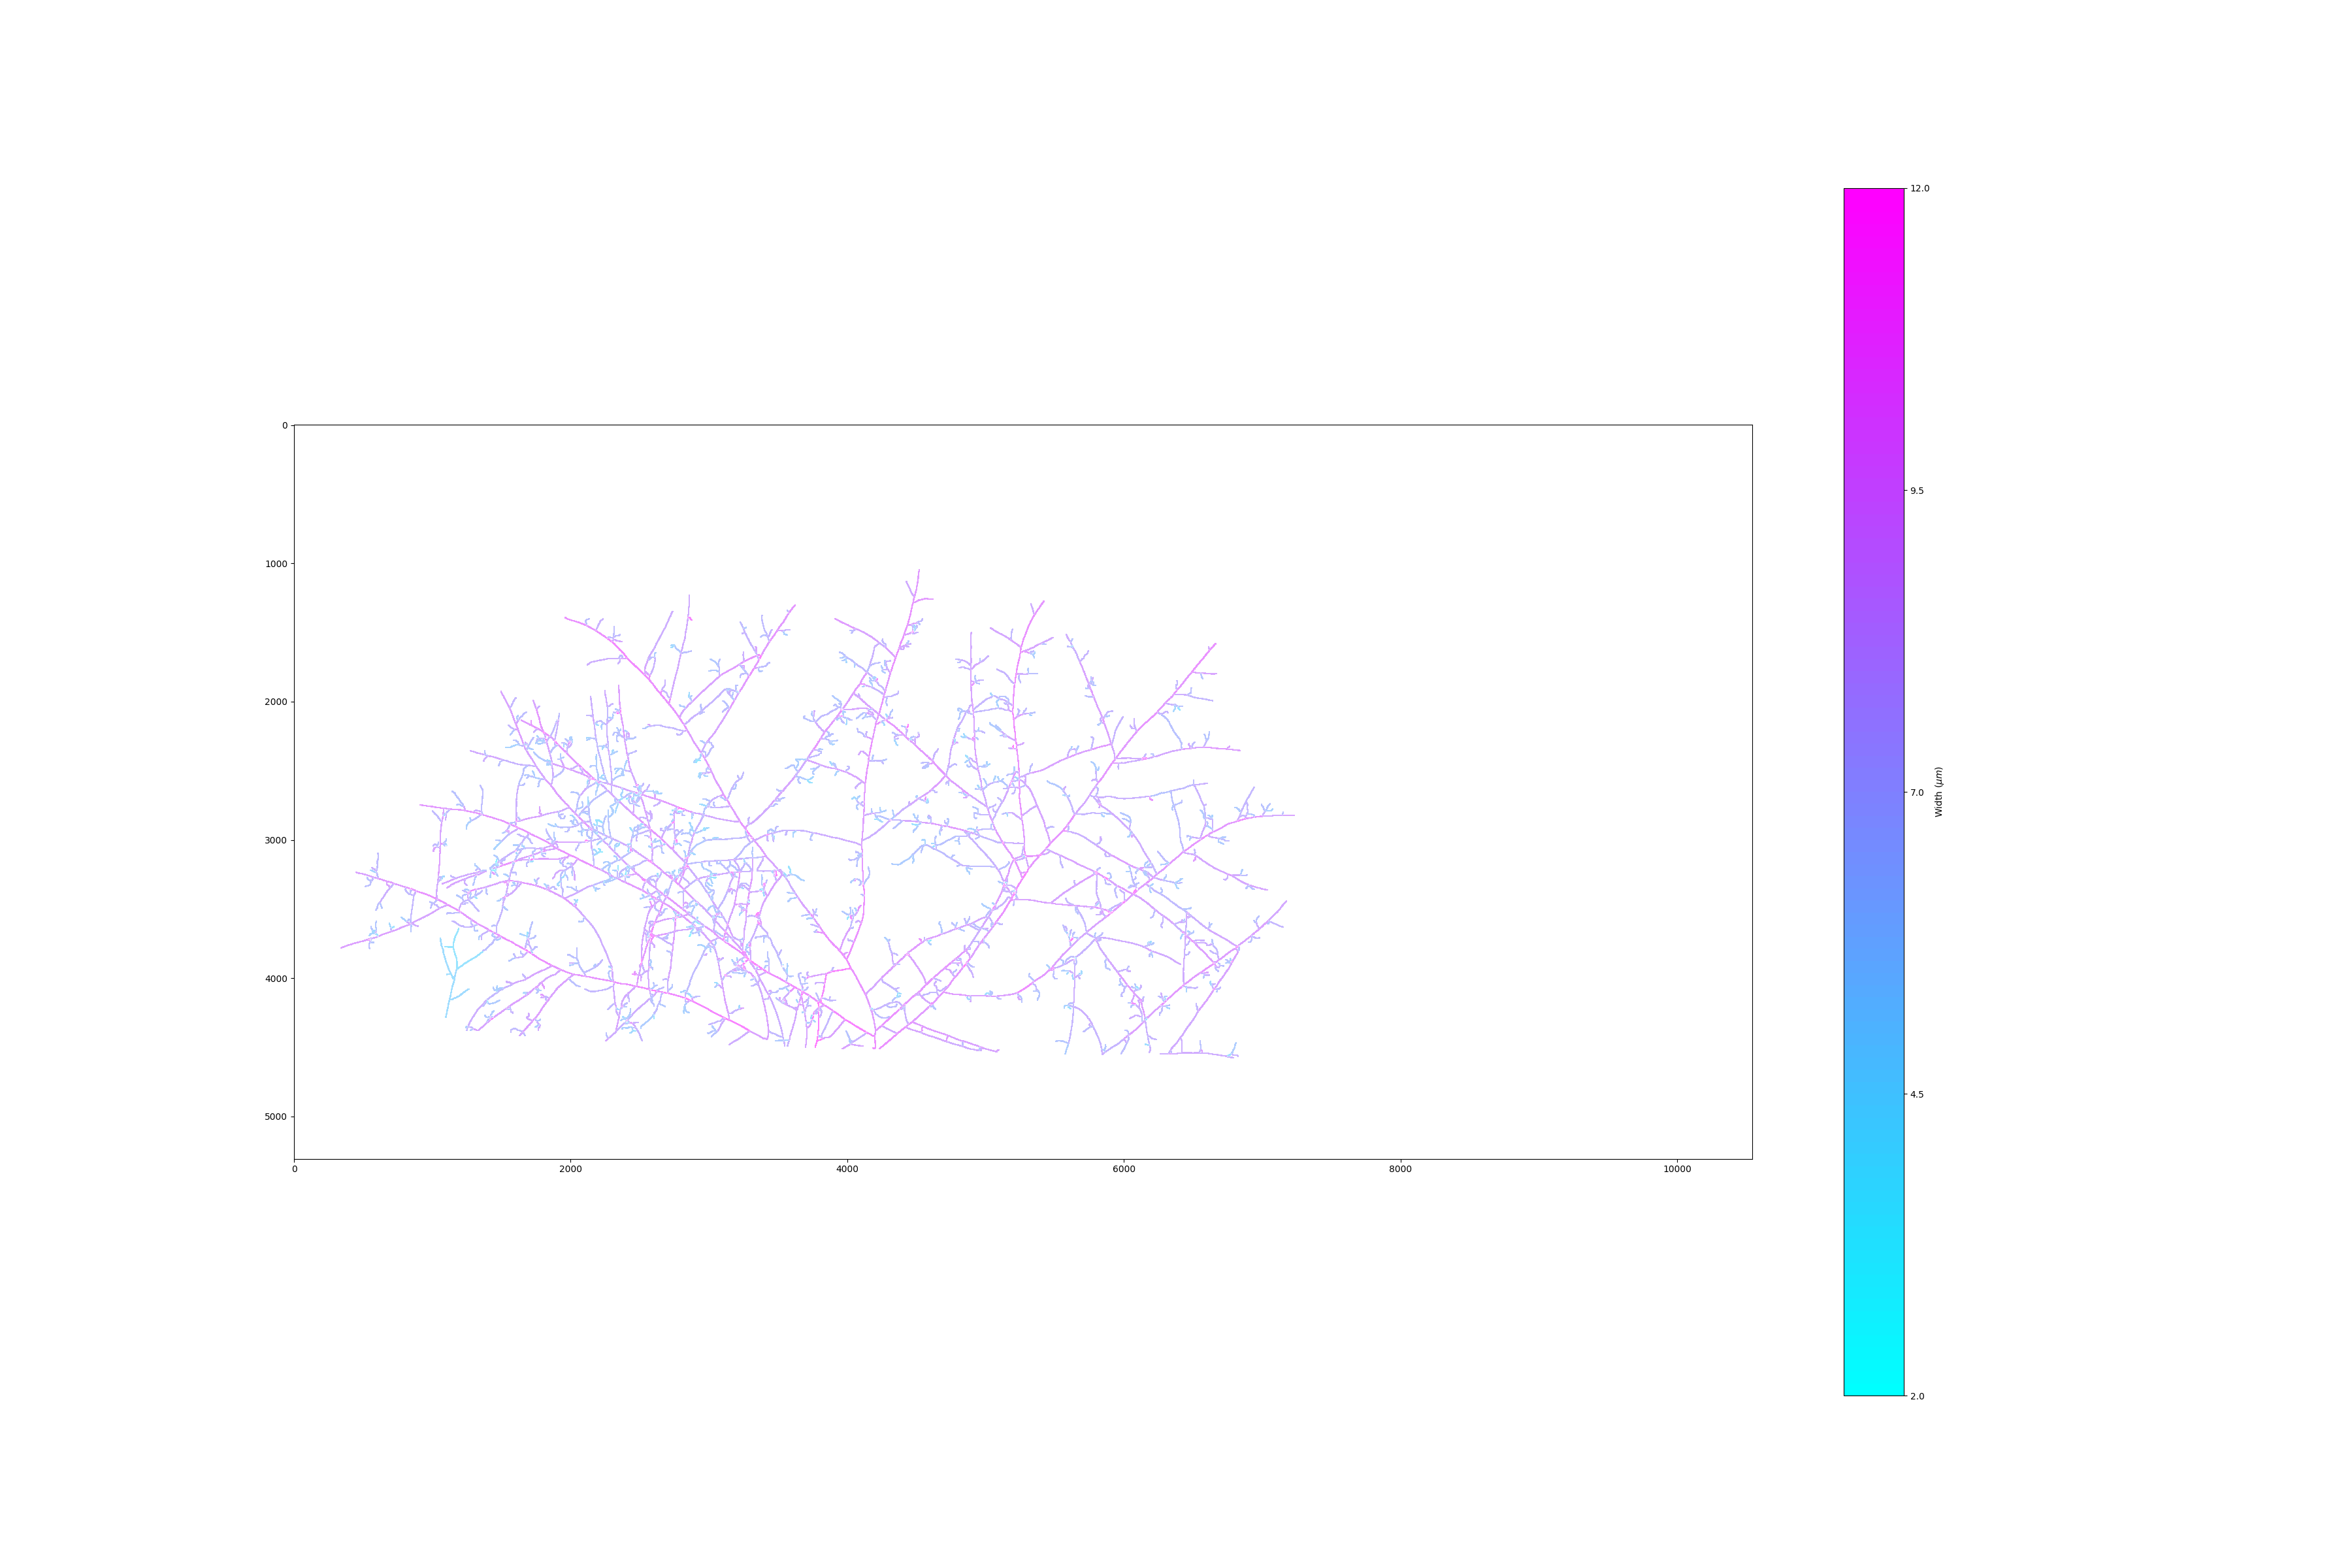

NameError: name 'dpi' is not defined

In [6]:
vmax = 12
vmin = 2
plot_edge_color_value(exp,t,lambda edge : edge.width(t),cmap = cm.get_cmap("cool", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f'width.png'
save_path = os.path.join(path,file_name)
plt.savefig(save_path, dpi=dpi)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


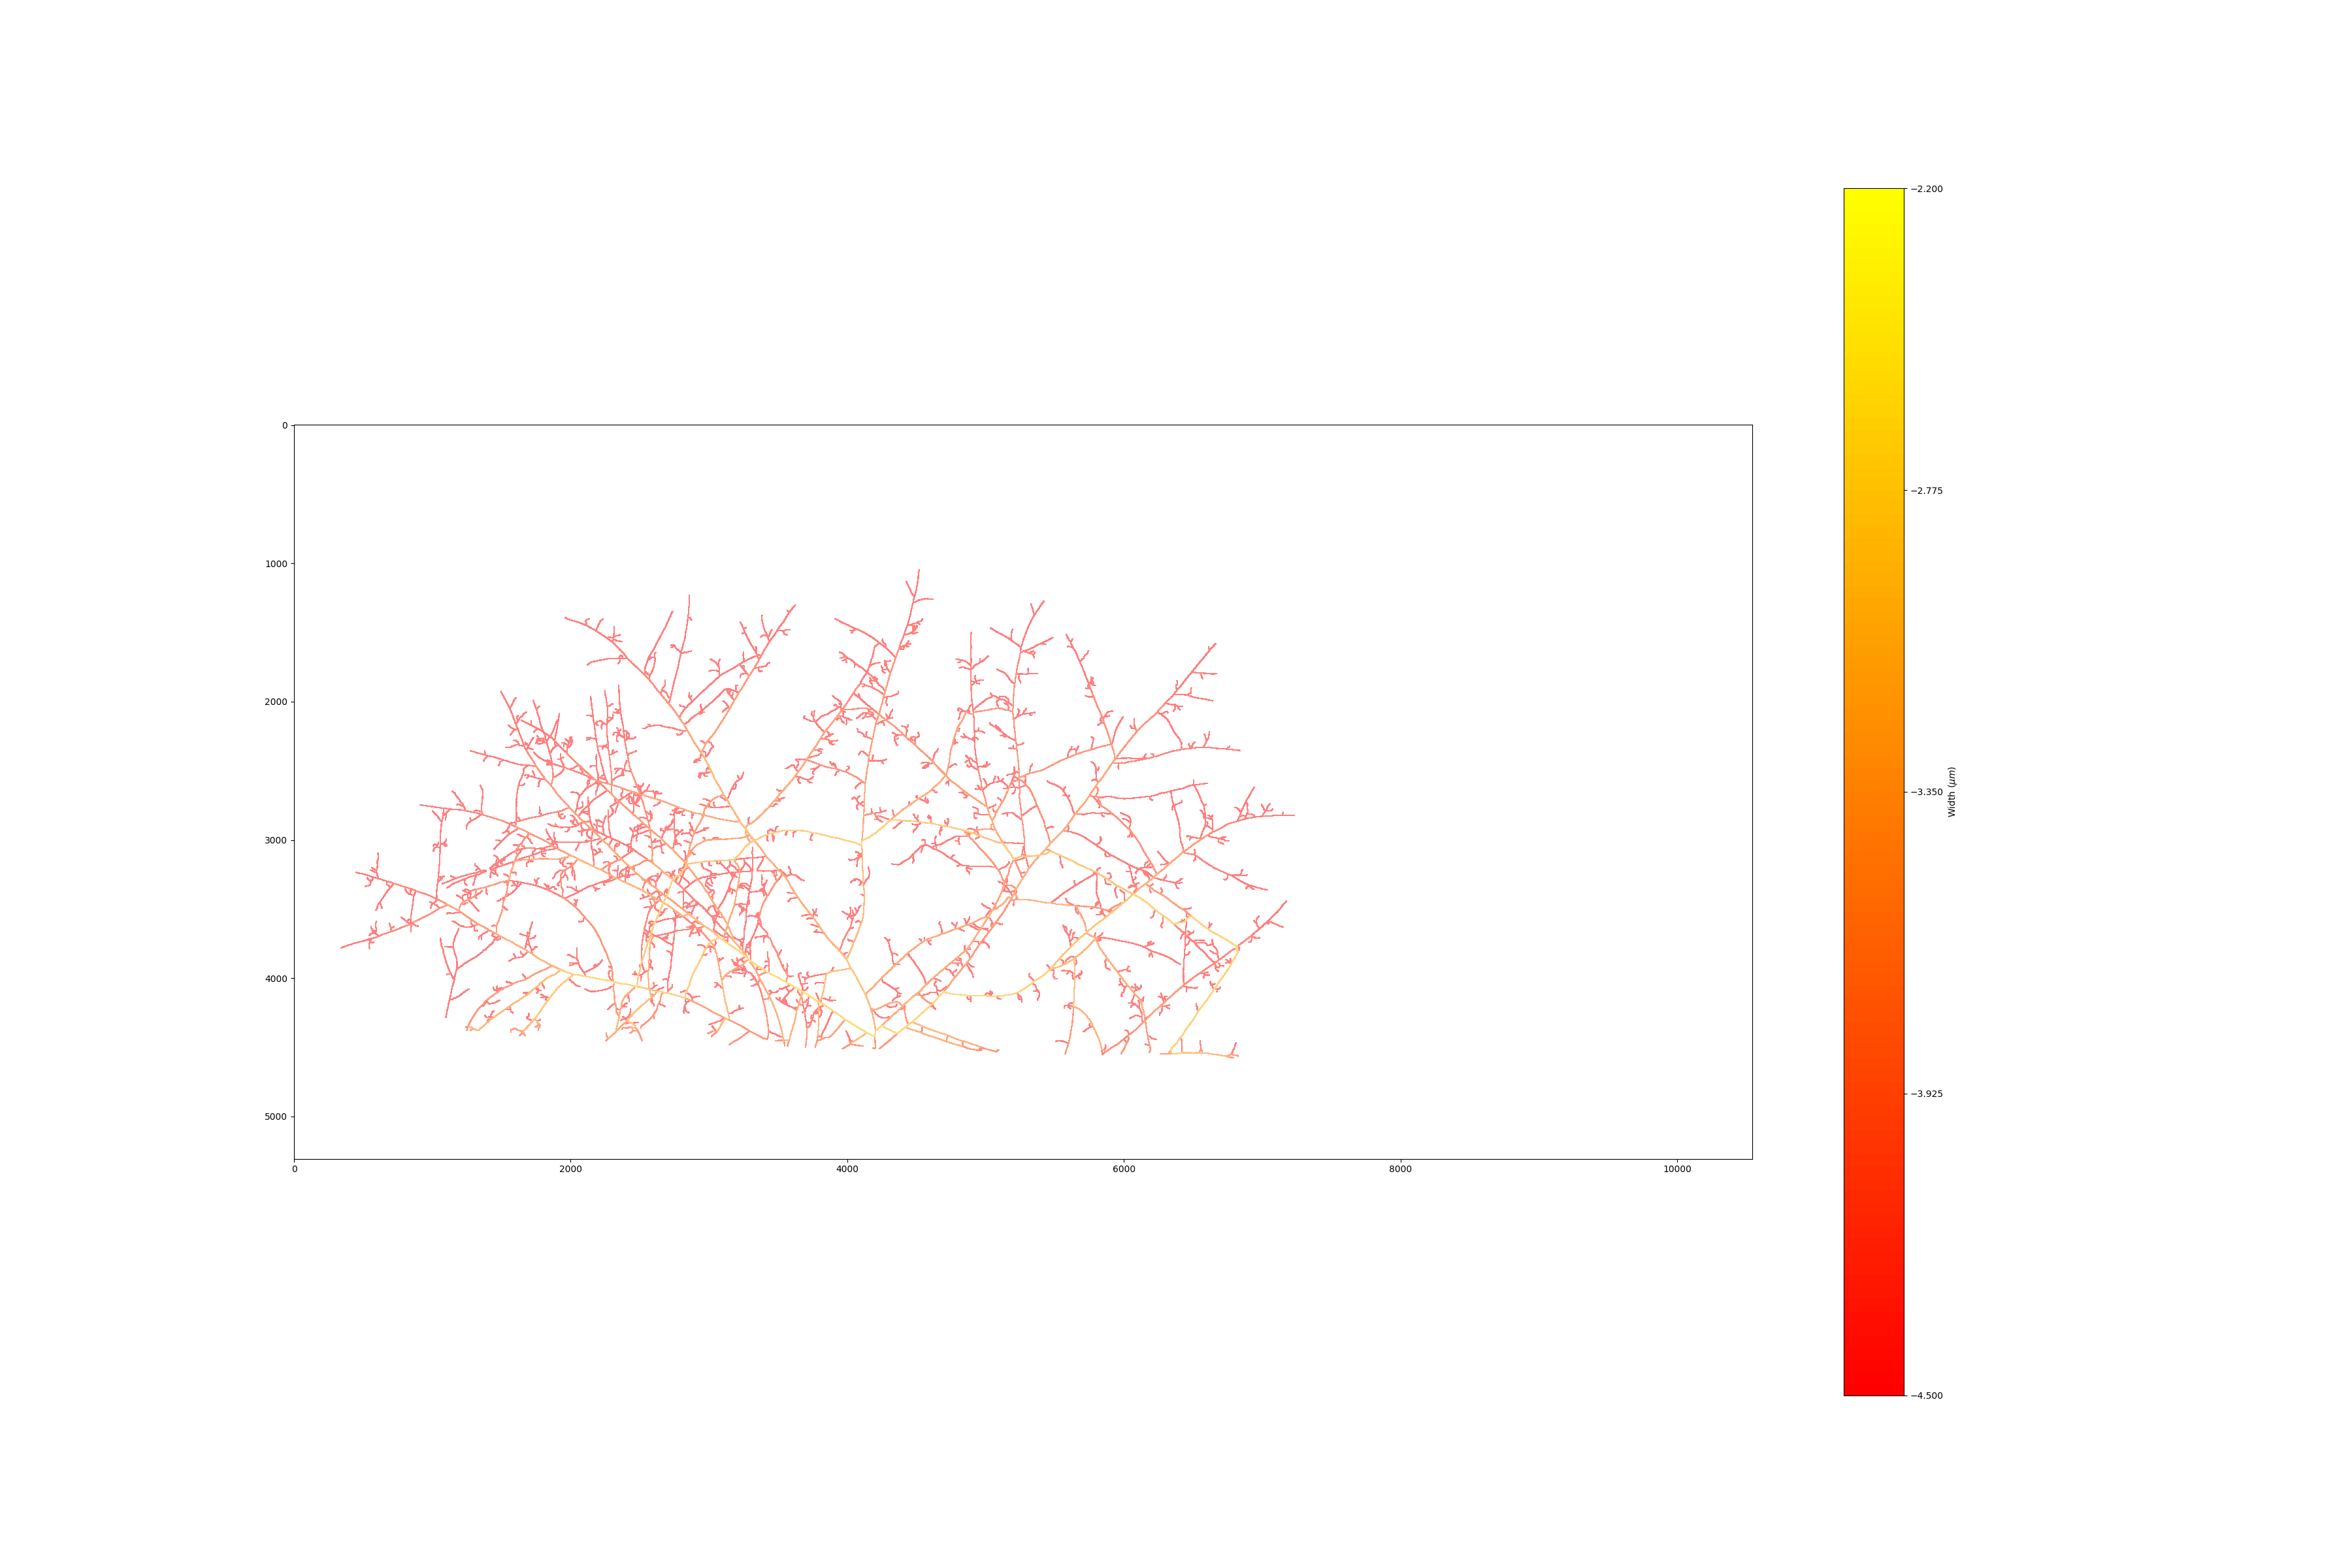

In [23]:
plt.close('all')
vmax = -2.2
vmin = -4.5
ax = plot_edge_color_value(exp,t,lambda edge : np.log10(edge.betweeness(t)),cmap = cm.get_cmap("autumn", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f'betweeness.png'
save_path = os.path.join(path,file_name)
plt.savefig(save_path, dpi=dpi)

In [ ]:
plt.close('all')
vmax = -2.2
vmin = -4.5
ax = plot_edge_color_value(exp,t,lambda edge : np.log10(edge.current_flow_betweeness(t)),cmap = cm.get_cmap("cool", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f'betweeness_random.png'
save_path = os.path.join(path,file_name)
plt.savefig(save_path, dpi=dpi)
file_name = f'betweeness_random.csv'
save_path = os.path.join(path,file_name)
plt.savefig(save_path)
file_name = f'betweeness_random.eps'
save_path = os.path.join(path,file_name)
plt.savefig(save_path)

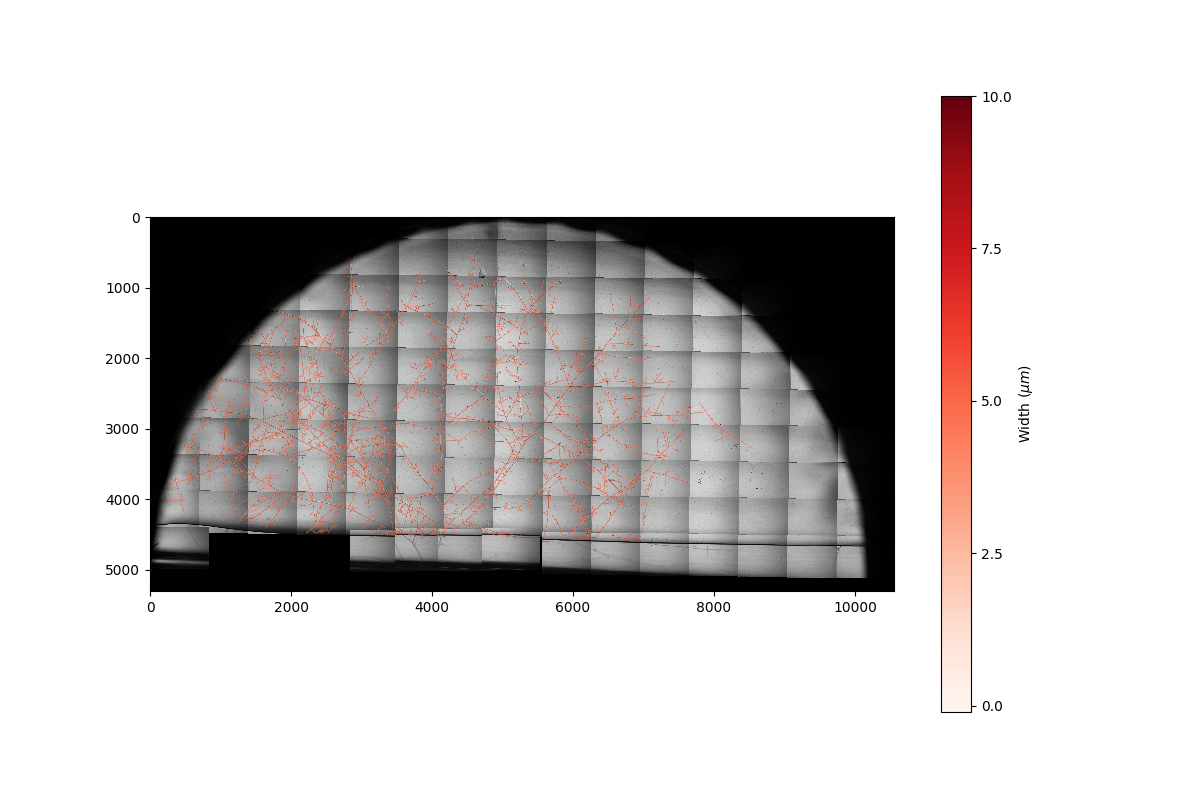

In [7]:
vmax = 0
vmin = 10
dpi=400

ax = plot_edge_color_value(exp,t,lambda edge : 5,cmap = cm.get_cmap("Reds", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=True,dilation =10,figsize = (12,8))
ax.scatter(spore_datatable['y']/5,spore_datatable['x']/5,s = 20,color = 'blue',alpha = 0.4)
path = r"/scratch-shared/amftrack/transport/full_picture/"
file_name = f'spores.png'
save_path = os.path.join(path,file_name)
plt.savefig(save_path, dpi=dpi)

In [7]:
edges = get_all_edges(exp, t)
nodes = get_all_nodes(exp, t)

In [8]:
nodes_source = [node for node in nodes if not is_in_study_zone(node,t,1000,150)[1] and is_in_study_zone(node,t,1000,150)[0]]

In [9]:

nodes_sink = [node for node in nodes if is_in_study_zone(node,t,1000,150)[1] and node.degree(t)==1]
# nodes_sink = [node for node in nodes if is_in_study_zone(node,t,1000,150)[1] ]

In [16]:
len(nodes_source),len(nodes_sink)

(138, 852)

In [10]:
weights = {(edge.begin.label,edge.end.label) : edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t] , weights, "length")
weights = {(edge.begin.label,edge.end.label) : 1/edge.length_um(t) for edge in edges}
nx.set_edge_attributes(exp.nx_graph[t] , weights, "1/length")

In [32]:
t =0
G = exp.nx_graph[t]
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len_connected=[len(nx_graph.nodes) for nx_graph in S]
final_current_flow_betweeness = {}
final_betweeness = {}

for g in S:
    source = [node.label for node in nodes_source if node.label in g]
    sink = [node.label for node in nodes_sink if node.label in g]
    current_flow_betweeness = nx.edge_current_flow_betweenness_centrality_subset(g,source,sink,weight = "1/length")
    betweeness = nx.edge_current_flow_betweenness_centrality_subset(g,sink,source,weight = "length")
    
    # betweeness = nx.edge_betweenness_centrality_subset(g,source,sink,normalized=True,weight = "length")
    for edge in current_flow_betweeness.keys():
        final_current_flow_betweeness[edge]=current_flow_betweeness[edge]
    for edge in betweeness.keys():
        final_betweeness[edge]=betweeness[edge]
        
for edge in exp.nx_graph[t].edges:
    if edge not in final_current_flow_betweeness.keys() and (edge[1],edge[0]) not in final_current_flow_betweeness.keys():
        final_current_flow_betweeness[edge] = 0
    if edge not in final_betweeness.keys() and (edge[1],edge[0]) not in final_betweeness.keys():
        final_betweeness[edge] = 0        
nx.set_edge_attributes(exp.nx_graph[t] , final_current_flow_betweeness, "current_flow_betweenness")
nx.set_edge_attributes(exp.nx_graph[t] , final_betweeness, "betweenness")
betweenessses = list(final_current_flow_betweeness.values())
np.mean(betweenessses),np.max(betweenessses)


(0.0002276309625805852, 0.0019489357368749837)

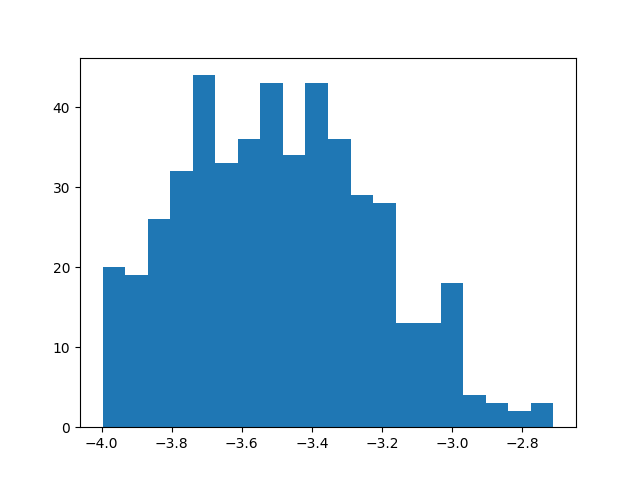

In [30]:
betweenessses = list(final_current_flow_betweeness.values())
betweenessses2 = list(final_betweeness.values())
fig,ax = plt.subplots()
h = ax.hist(np.log10([bet for bet in betweenessses if bet >1e-4]),20)

In [16]:
final_current_flow_betweeness[(527418, 512522)],final_betweeness[(527418, 512522)]

(0.0004879946616729095, 0.00048799466167290923)

In [12]:
final_current_flow_betweeness[(527418, 512522)],final_betweeness[(527418, 512522)]

(0.0004879946616729095, 0.000504582530241318)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


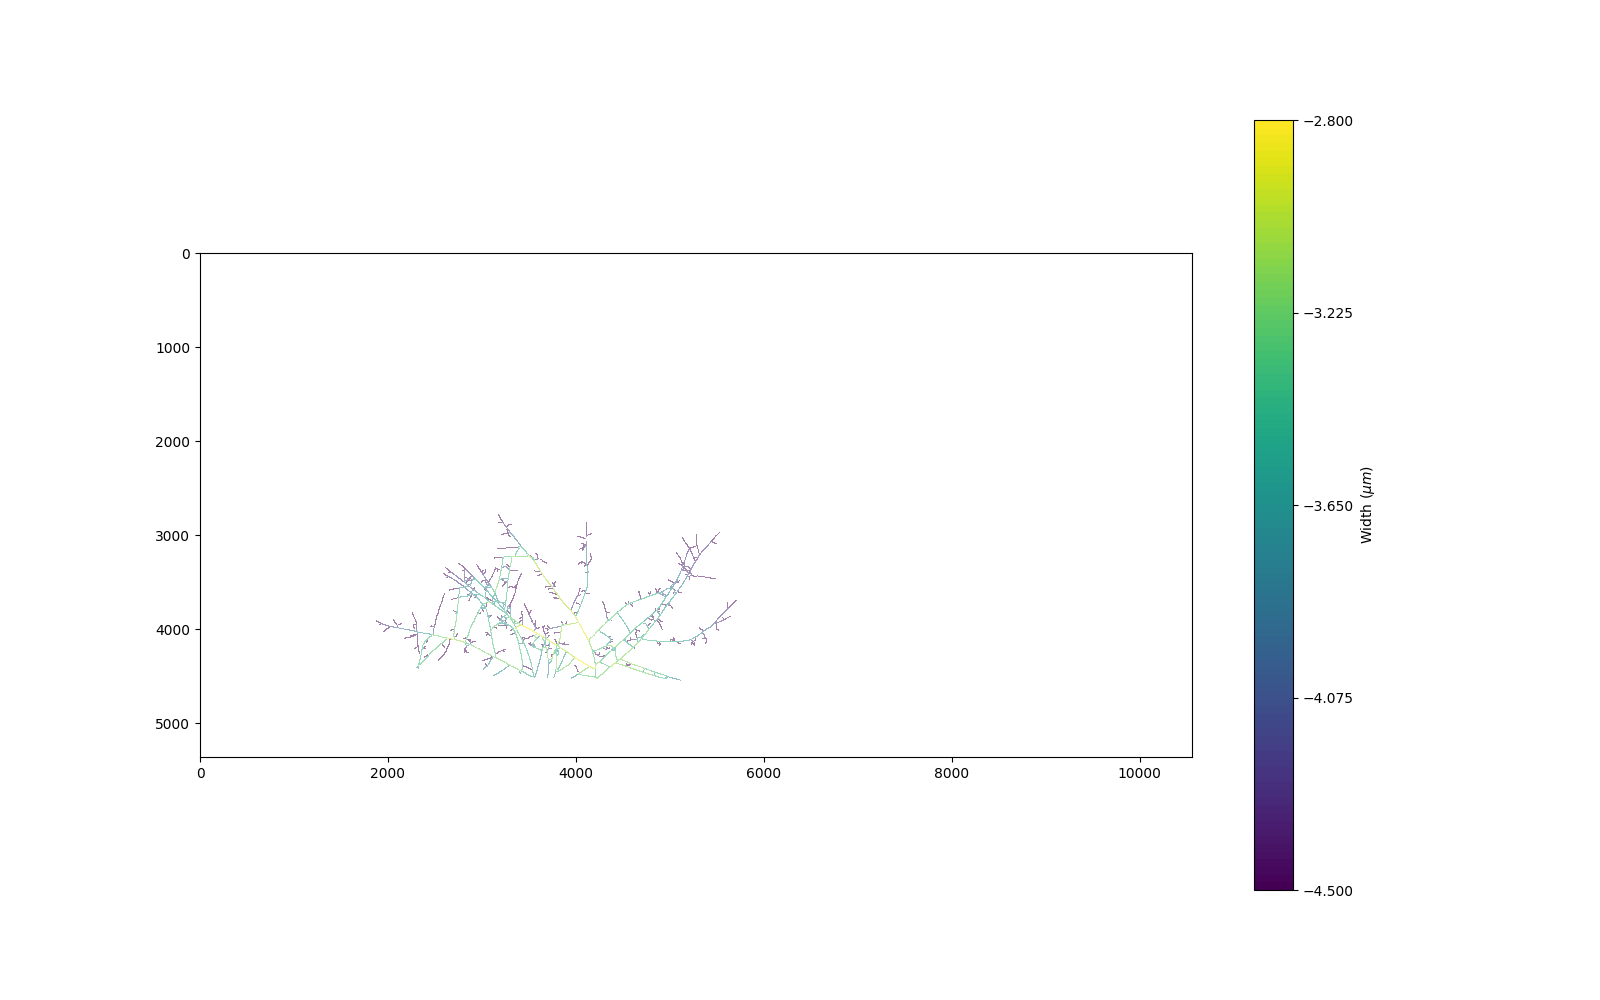

In [33]:
plt.close('all')
vmax = -2.8
vmin = -4.5
ax = plot_edge_color_value(exp,t,lambda edge : np.log10(edge.current_flow_betweeness(t)),cmap = cm.get_cmap("viridis", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10,figsize = (16,10))
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'betweeness_random.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


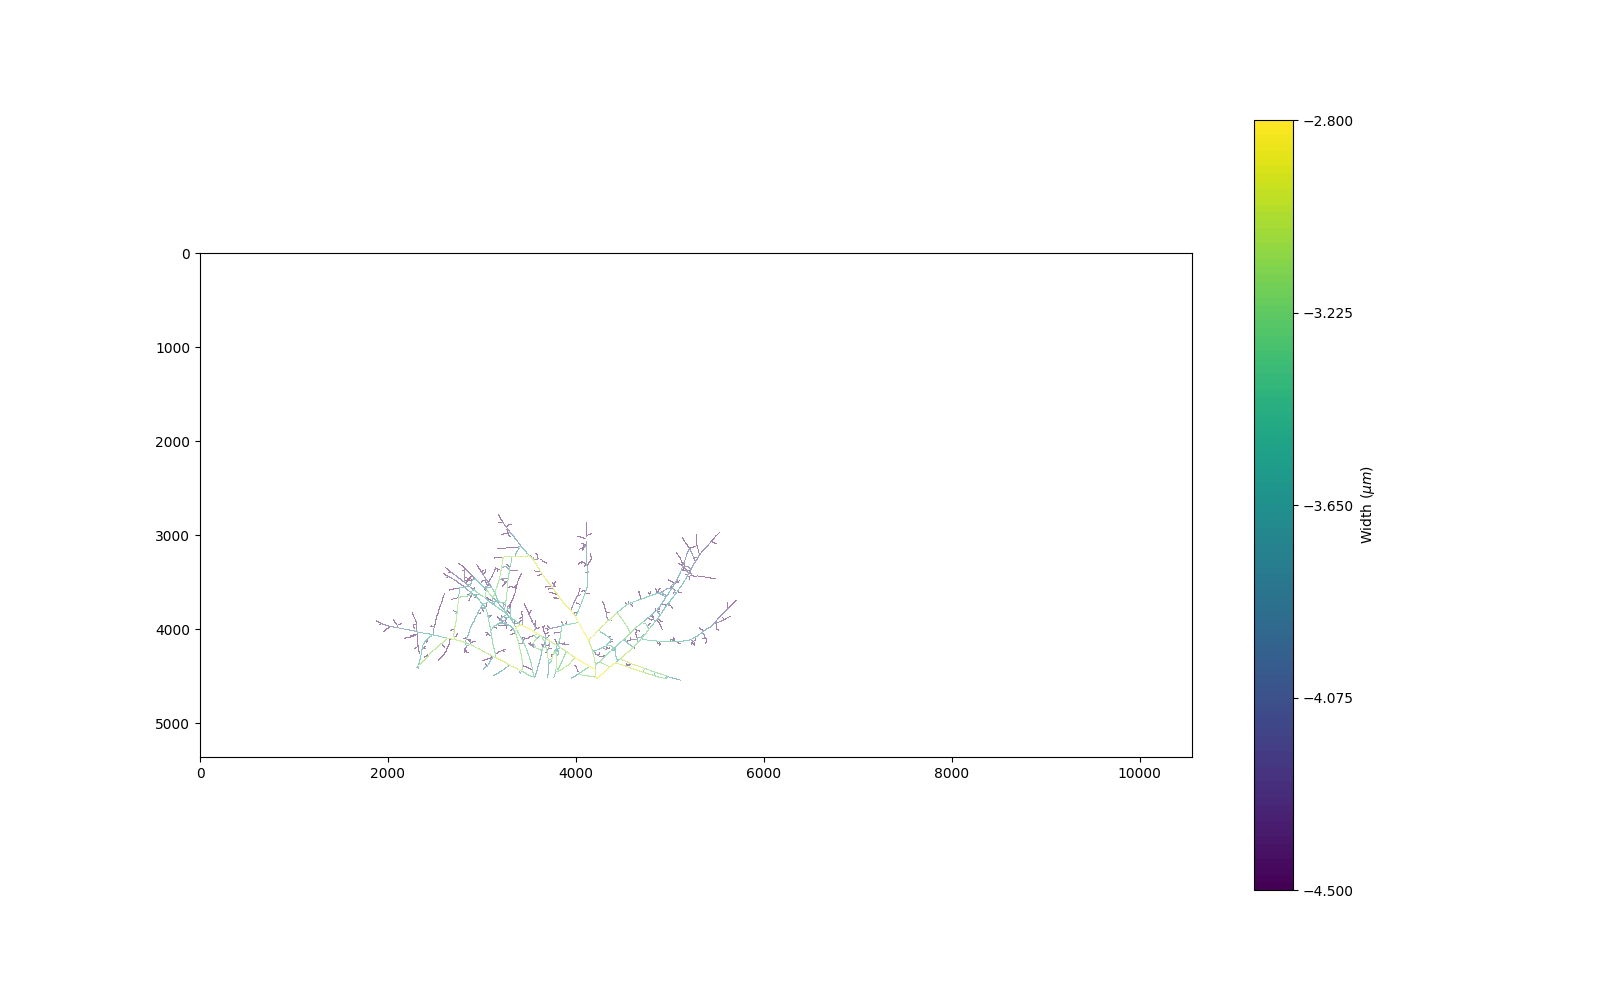

In [35]:
vmax = -2.8
vmin = -4.5
ax = plot_edge_color_value(exp,t,lambda edge : np.log10(edge.betweeness(t)),cmap = cm.get_cmap("viridis", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10,figsize = (16,10))
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'betweeness_random.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


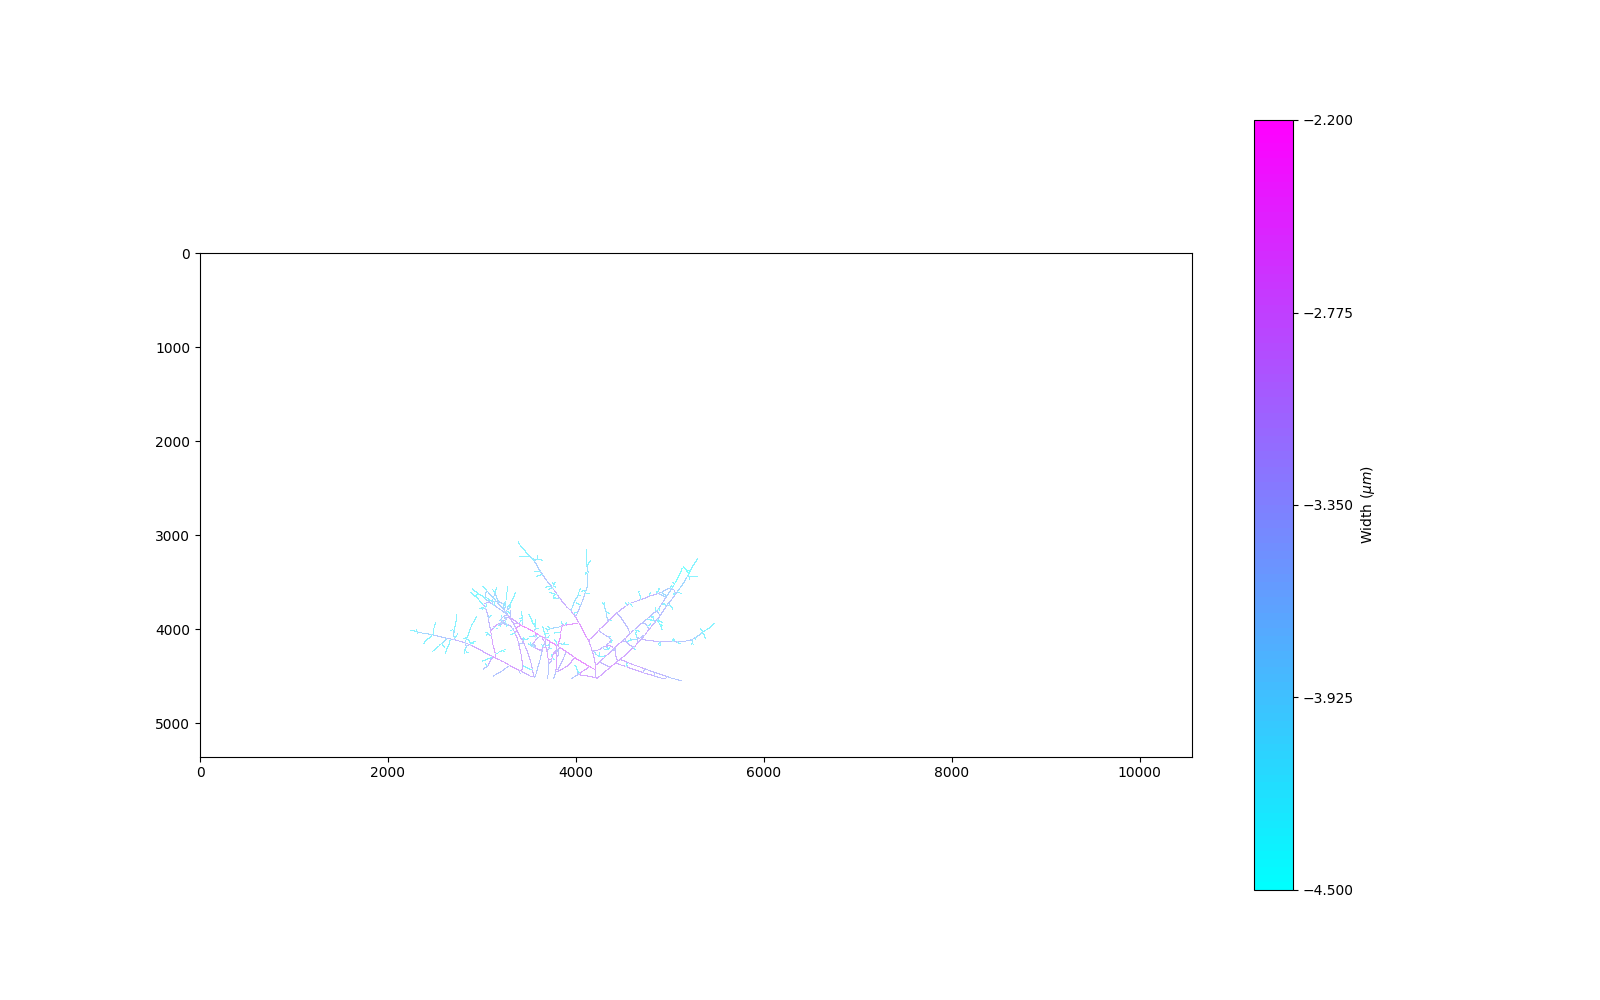

In [24]:
plt.close('all')
vmax = -2.8
vmin = -4.5
ax = plot_edge_color_value(exp,t,lambda edge : np.log10(edge.current_flow_betweeness(t)),cmap = cm.get_cmap("cool", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10,figsize = (16,10))
# path = r"/scratch-shared/amftrack/transport/full_picture/"
# file_name = f'betweeness_random.png'
# save_path = os.path.join(path,file_name)
# plt.savefig(save_path, dpi=dpi)

In [ ]:
betweenessses = list(current_flow_betweeness.values())
vmax = np.log10(np.max(betweenessses))
vmax

In [ ]:
betweenessses = [edge.current_flow_betweeness(t) for edge in edges]
betweenessses = [betweeness for betweeness in betweenessses if betweeness>1e-5]
np.max(betweenessses),np.mean(betweenessses)
fig,ax = plt.subplots()
ax.hist(np.log10(betweenessses))

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


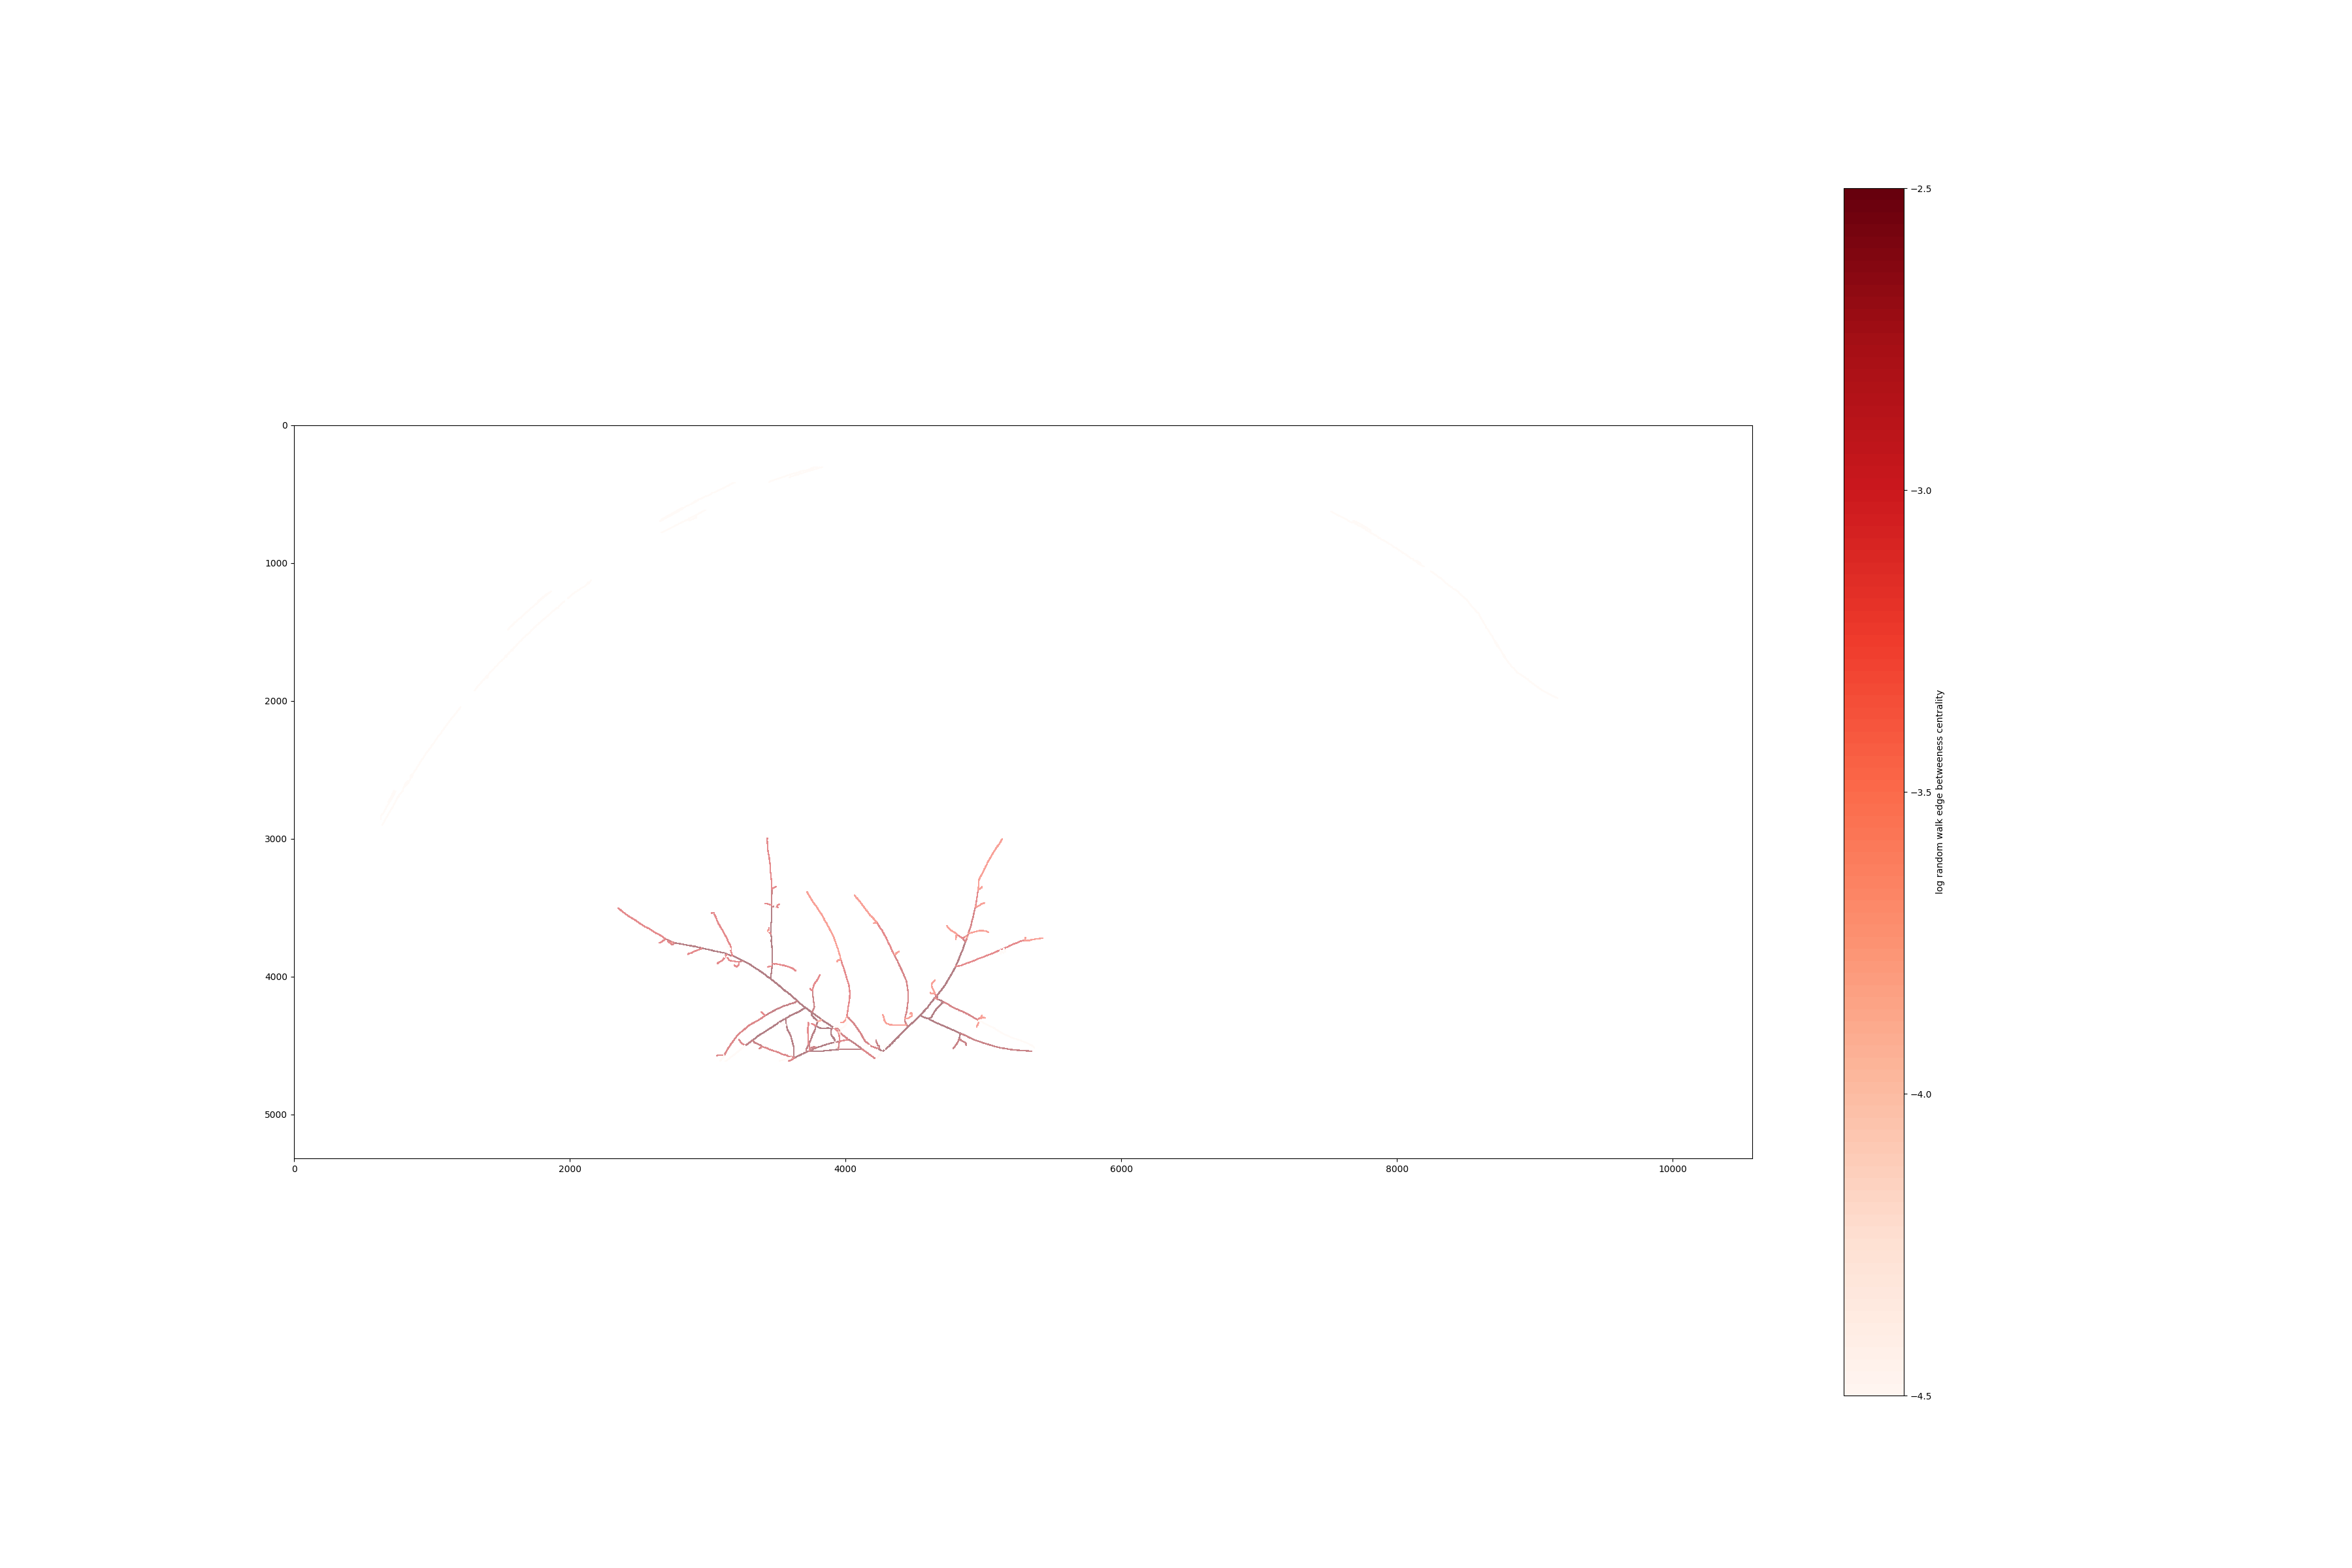

<AxesSubplot:>

In [ ]:
plt.close("all")
# betweenessses = list(current_flow_betweeness.values())
vmax = -2.5
vmin = -4.5

plot_edge_color_value(exp,t,lambda edge : np.log10(edge.current_flow_betweeness(t)),cmap = cm.get_cmap("Reds", 100),v_min =vmin,v_max = vmax,plot_cmap=True,show_background=False,dilation =10,label_colorbar = "log random walk edge betweeness centrality")

In [ ]:
betweenessses = [edge.betweeness(t) for edge in edges]
betweenessses = [betweeness for betweeness in betweenessses if betweeness>0]
np.max(betweenessses),np.mean(betweenessses)
fig,ax = plt.subplots()
ax.hist(np.log10(betweenessses))